# Model selection

**Important NOTE**: in this notebook, the `y` variable is: 0 = not Joe, 1 = Joe.

## Load the labeled dataset

In [1]:
import pandas as pd
import numpy as np


# Swap between small and big feature set:
# suffix = "sm"
suffix = "big"

sessions_fp = f"results/training.sessions-expanded-numerical.{suffix}.csv.gz"
features_fp = f"results/features.{suffix}.list"
thresholds_dir = f"results/models_{suffix}"
models_dir = f"results/models_{suffix}"

sessions = pd.read_csv(sessions_fp, index_col="session_id")

# A nicer order for the features:

all_cols = sessions.columns.tolist()

prefix_order = [
    "gender",
    "os",
    "browser",
    "locale",
    "location",
    "weekday",
    "url",
]

simple_features = [
    "hour",
    "day",
    "month",
    "year",
    "duration_min",
    "n_sites",
]

new_order = ["is_joe"]
new_order += simple_features
for prefix in prefix_order:
    prefix_cols = [c for c in all_cols if c.startswith(prefix)]
    new_order += prefix_cols
    
assert len(all_cols) == len(new_order)

sessions = sessions.reindex(columns=new_order)
sessions

,is_joe,hour,day,month,year,duration_min,n_sites,gender_f,gender_m,os_Debian,...,url_wjscore.com,url_wurstclient.net,url_xxrisetube.com,url_yahoo.com,url_yammerusercontent.com,url_youtube.com,url_yqnapttsst.in,url_yswcdn.com,url_ytimg.com,url_zaubacorp.com
session_id,,,,,,,,,,,,,,,,,,,,,
0,0,3,14,8,2016,30,14,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,13,31,5,2016,23,12,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,17,15,4,2019,19,12,0,1,0,...,0,0,0,138,0,0,0,0,0,0
3,0,20,25,3,2018,27,15,1,0,0,...,0,0,0,0,0,0,0,0,184,0
4,0,1,8,9,2018,17,11,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,0,22,15,10,2018,19,12,1,0,0,...,0,0,0,0,0,0,0,0,0,0
159996,0,21,23,3,2016,35,12,1,0,0,...,0,0,0,0,0,125,0,0,0,0
159997,0,19,3,3,2019,28,15,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Split `X` and `y`

In [2]:
print(len(sessions.columns), "features")

y = sessions["is_joe"]
sessions.drop("is_joe", axis=1, inplace=True)
X = sessions

with open(features_fp, "w+") as f:
    for feature in X.columns:
        f.write(f"{feature}\n")

312 features


As can be seen, we are dealing with imbalanced classes:

In [3]:
display(y.value_counts())
print("---")
display(100 * y.value_counts(normalize=True))

0    159200
1       800
Name: is_joe, dtype: int64

---


0    99.5
1     0.5
Name: is_joe, dtype: float64

### Split training and testing datasets

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=0.75, random_state=40)

In [5]:
print(X_train.shape, "training set")
print(X_test.shape, "testing set")

(120000, 311) training set
(40000, 311) testing set


# Train models

We define the desired models to compare:

## F1 scoring on different competing models with stratified 5-fold cross validation

- Stratified K-fold cross validation is a type of k-fold CV that tries to keep the class ratios of the response variable in both train and test sets during CV. This is useful for hiighly imbalanced classes like Joe / Not Joe (0.5% / 99.5%). See [sklearn reference](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold).

- $F_1$ score is one type of F-score that takes into account with equal weights both the precision (ratio of sessions predicted as Joe that are actually Joe) and the recall (ratio of the Joe-sessions that are caught by the predictor). We care about this since meassuring the accuracy with such a class imbalance would be misleading. See [the wiki](https://en.wikipedia.org/wiki/F-score).

Note: we could try $F_2$ score in the future to put more importance on the recall.

In [6]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

We will use F1 to score the models since we specially care about precision and recall in this experiment.

In [26]:
from datetime import datetime

logistic_opts = dict(
    multi_class="ovr",
    max_iter=2000,
)

models = {
    
    "Logistic_nobalance": LogisticRegression(**logistic_opts),
    "Logistic_balanced": LogisticRegression(class_weight="balanced", **logistic_opts),
    
    "DT": DecisionTreeClassifier(criterion="entropy"),
}

# https://machinelearningmastery.com/bagging-ensemble-with-python/
for n in [10, 20, 50, 100, 150, 200, 250, 300]:
    
    model_name = f"Bagging_{n}DTs"
    model = BaggingClassifier(
        DecisionTreeClassifier(criterion="entropy"),
        # I found 'entropy' performs better than gini in previous iterations
        n_estimators=n,
    )
    models[model_name] = model

for n in [10, 20, 50, 100]:
    model_name = f"RandomForest_{n}DTs"
    models[model_name] = RandomForestClassifier(n_estimators=n, n_jobs=3)

In [165]:
# scores = {} # Uncomment to clear the scorings
    
for model_name, model in models.items():
    print(f"[{datetime.now()}] {model_name} F1 =", end=" ")
    
    if model_name not in scores:
        cv = StratifiedKFold(n_splits=5)
        model_scores = cross_val_score(
            model,
            X_train,
            y_train,
            scoring="f1",
            cv=cv,
            n_jobs=2
        )
        scores[model_name] = model_scores
        
    model_scores = scores[model_name]
    print(f"{np.mean(model_scores):.2} std = {np.std(model_scores):.3}")

[2022-05-28 15:06:12.955169] Logistic_nobalance F1 = 0.055 std = 0.0381
[2022-05-28 15:06:12.955574] Logistic_balanced F1 = 0.15 std = 0.0143
[2022-05-28 15:06:12.955810] DT F1 = 0.62 std = 0.025
[2022-05-28 15:06:12.955980] Bagging_10DTs F1 = 0.59 std = 0.0318
[2022-05-28 15:06:12.956143] Bagging_20DTs F1 = 0.62 std = 0.0258
[2022-05-28 15:06:12.956302] Bagging_50DTs F1 = 0.61 std = 0.0366
[2022-05-28 15:06:12.956497] Bagging_100DTs F1 = 0.63 std = 0.0375
[2022-05-28 15:06:12.956652] Bagging_150DTs F1 = 0.62 std = 0.0325
[2022-05-28 15:06:12.956763] Bagging_200DTs F1 = 0.63 std = 0.0374
[2022-05-28 15:06:12.956867] Bagging_250DTs F1 = 0.63 std = 0.0411
[2022-05-28 15:06:12.956966] Bagging_300DTs F1 = 0.62 std = 0.0433
[2022-05-28 15:06:12.957063] RandomForest_10DTs F1 = 0.38 std = 0.028
[2022-05-28 15:06:12.957159] RandomForest_20DTs F1 = 0.38 std = 0.0766
[2022-05-28 15:06:12.957287] RandomForest_50DTs F1 = 0.44 std = 0.0346
[2022-05-28 15:06:12.957398] RandomForest_100DTs F1 = 0.44 

The Bagging Classifier outperforms the rest. Surprisingly, only one decision tree ("DT") seems to be as good as bagging multiple DTs. The performance of bagged DTs seems to converge around $F_1 = 0.63$, at least with the chosen set of features. Increasing the number of DTs gives marginal increases of performance, so somewhere between 50 and 100 DTs seems enough.

We will choose a Bagging Classifier with 100 Decision trees because it gives some flexibility to choose the desired precision/recall tradeoff.

Logisitic regression and random forests perform worse.

## Train models/parameters on the full training dataset

In [27]:
import pickle
from os.path import isfile


def model_fp(model_name):
    # *models_dir* defined outside
    return f"{models_dir}/{model_name}.pickle"

def dump_model(model, model_name):
    with open(model_fp(model_name), "wb") as f:
        pickle.dump(model, f)
        
def load_model(model_name):
    with open(model_fp(model_name), "rb") as f:
        return pickle.load(f)
        
def is_saved(model_name):
    return isfile(model_fp(model_name))


fitted_models = {}

for model_name in models:

    if is_saved(model_name):
        fitted_models[model_name] = load_model(model_name)
        continue

    model = models[model_name]
    # print(f"[{datetime.now()}] Fit {model}")
    
    fitted_models[model_name] = model.fit(X_train, y_train)
    dump_model(model, model_name)

## Compare the precision-recall curves of the models on the test set

  0%|          | 0/6 [00:00<?, ?it/s]

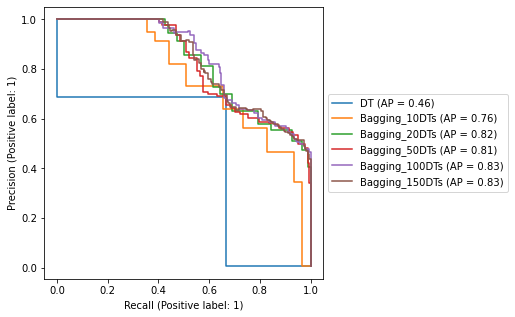

  0%|          | 0/9 [00:00<?, ?it/s]

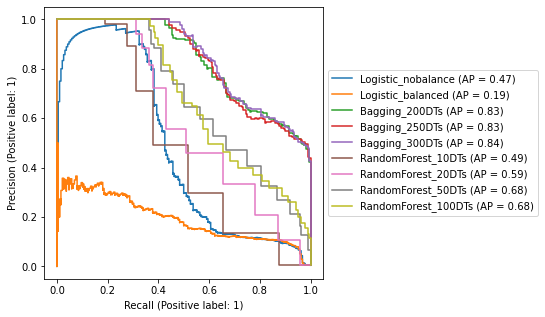

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from tqdm.notebook import tqdm


first_group = [name for name in fitted_models.keys()
               if name == "DT" or "Bagging" in name][:6]
second_group = [name for name in fitted_models.keys()
                if name not in first_group]

for group in [first_group, second_group]:
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    for model_name in tqdm(group):
        model = fitted_models[model_name]
        PrecisionRecallDisplay.from_estimator(
            model, X_test, y_test, name=model_name, ax=ax
        )

    plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
    plt.show()

It is interesting that Random Forests performed worse than Bagging DTs. The subselection of features in RF did not help to generalize?

In [32]:
chosen_model_name = "Bagging_100DTs"
chosen_model = fitted_models[chosen_model_name]
print(chosen_model)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                  n_estimators=100)


# Chosen model analysis

## Choosing the probability threshold to predict Joe

Given the precision-recall tradeoff, we want to settle on a default probability threshold to predict Joe.

In [418]:
sessions_original = pd.read_json("data/dataset.json")
sessions_original["is_joe"] = sessions_original["user_id"] == 0
sessions_original.index.name = "session_id"

In [419]:
y_probs = chosen_model.predict_proba(X_test)

performance = pd.DataFrame(y_probs, columns=["prob_other", "prob_joe"])
performance["y_test"] = y_test.values
performance.index = y_test.index
performance.index.name = "session_id"
performance = performance.join(sessions_original)

# make sure we merged correctly:
assert all(performance["y_test"] == performance["is_joe"])

performance["is_joe"] = performance["is_joe"].astype(bool)

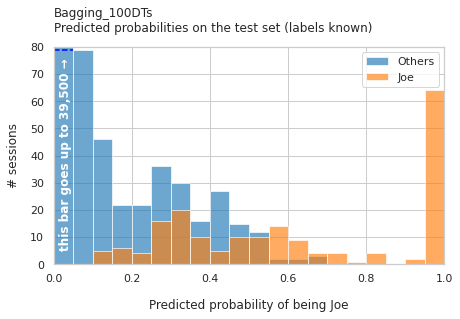

In [511]:
import seaborn as sns

sns.set_context("notebook")

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
n_joe_sessions = y_test.sum()

bins = np.arange(0, 1.05, step=0.05)

for is_joe, df in performance.groupby("is_joe"):
    label = "Joe" if is_joe else "Others"
    df["prob_joe"].plot.hist(bins=bins, alpha=0.65, label=label, ax=ax)

ax.text(0.030, 5, "this bar goes up to 39,500 →",
        color="white", ha="center", va="bottom", rotation=90,
        fontweight="bold")
ax.plot([0, 0.05], [79, 79], color="blue", ls="dashed")
    
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 80)
ax.set_xlabel("Predicted probability of being Joe", labelpad=15)
ax.set_ylabel("# sessions", labelpad=10)
_ = ax.set_title(
    f"{chosen_model_name}\nPredicted probabilities on the test set (labels known)",
    loc="left", pad=15
)

When producing probability values instead of 0/1 predictions, we see there is a smaller group of Joe-sessions with intermediate assigned probabilities, but most Joe-sessions have high assigned probability of begin Joe.

False negatives (sessions predicted as "Other" but that were actually Joe's) com from Paris mainly, both with Ubuntu/Win10 and Firefox/Chrome:

In [435]:
false_negatives = performance.query("is_joe and prob_joe < 0.5")

for col in ["location", "os", "browser"]:
    display( 100 * false_negatives[col].value_counts(normalize=True).round(3) )

France/Paris           68.4
USA/Chicago            27.6
Singapore/Singapore     3.9
Name: location, dtype: float64

Ubuntu        50.0
Windows 10    50.0
Name: os, dtype: float64

Firefox    56.6
Chrome     43.4
Name: browser, dtype: float64

In [422]:
from sklearn.metrics import precision_recall_curve

thresholds = precision_recall_curve(y_test, performance.prob_joe)
thresholds = pd.DataFrame(thresholds).transpose()
thresholds.columns = ["precision", "recall", "threshold"]
thresholds = thresholds.set_index("threshold", drop=False)

thresholds["F1"] = thresholds.eval("2 * (precision * recall) / (precision + recall)")
thresholds["F2"] = thresholds.eval("5 * (precision * recall) / (4 * precision + recall)")

max_F1_thr = thresholds["F1"].idxmax()
max_F2_thr = thresholds["F2"].idxmax()

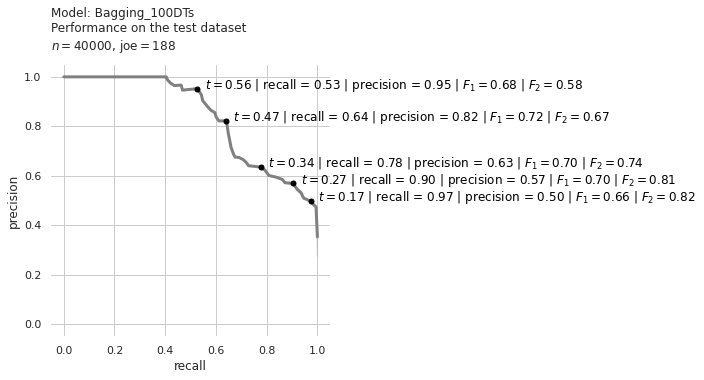

In [458]:
import seaborn as sns

thresholds["F1"] = thresholds.eval("2 * (precision * recall)/(precision + recall)")

possible_thresholds = [
    thresholds.loc[0.56],
    thresholds.loc[max_F1_thr],
    thresholds.loc[0.34],
    thresholds.loc[0.27],
    thresholds.loc[max_F2_thr],
]

sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.lineplot(
    data=thresholds,
    x="recall",
    y="precision",
    color="grey",
    lw=3,
    ax=ax,
)

for thr in possible_thresholds:
    ax.plot(thr.recall, thr.precision, "o", ms=5, color=color)
    ax.text(
        thr.recall + 0.03,
        thr.precision,
        f"$t = {thr.threshold}$ | "
        f"recall = {thr.recall:.2f} | "
        f"precision = {thr.precision:.2f} | "
        f"$F_1 = {thr.F1:.2f}$ | "
        f"$F_2 = {thr.F2:.2f}$ ",
        color=color
    )

    
n = len(y_test)
n_joe = sum(y_test)
n_others = n - n_joe

ax.set_title(
    f"Model: {chosen_model_name}\n"
    "Performance on the test dataset\n"
    f"$n = {n}$, $\mathrm{{joe}} = {n_joe}$",
    pad=15, loc="left"
)
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
sns.despine(bottom=True, left=True)

In [443]:
100 * thresholds.loc[[0.56, 0.47, 0.34, 0.27, 0.17]].round(3).drop("threshold",axis=1)

,precision,recall,F1,F2
threshold,,,,
0.56,95.2,52.7,67.8,57.8
0.47,82.2,63.8,71.9,66.8
0.34,63.5,77.7,69.9,74.3
0.27,56.9,90.4,69.8,80.9
0.17,49.9,97.3,65.9,81.8


There is a continuum of options that depend on **the cost of missing Joe vs the cost of catching Joe incorrectly**. Some example thresholds $t$ are:

t = 0.56 gives excelent precision (95% of Joe-predictions are good) but you catch Joe only 53% of the times.

t = 0.47 still gives good precision (82% of Joe-predictions are good) and you catch Joe 64% of the times. This threshold maximizes the $F_1$ score.

t = 0.34 gives acceptable precision (63% of Joe-predictions are good) and you catch Joe 78% of the times.

t = 0.17 gives poor precision (50% of predicionts of Joe are wrong), but you make sure you catch Joe 97% of the times. This threshold maximizes the $F_2$ score.

We will choose as default the compromise between 63% precision and 78% recall, with threshold $t=0.34$.

## Confusion matrix of the chosen model and threshold

In [429]:
chosen_threshold = 0.34

y_true = performance["y_test"].values
y_prob = performance["prob_joe"].values
y_pred = (y_prob >= chosen_threshold).astype(int)

print(y_true.shape)
print(y_pred.shape)
y_pred.mean()

(40000,)
(40000,)


0.00575

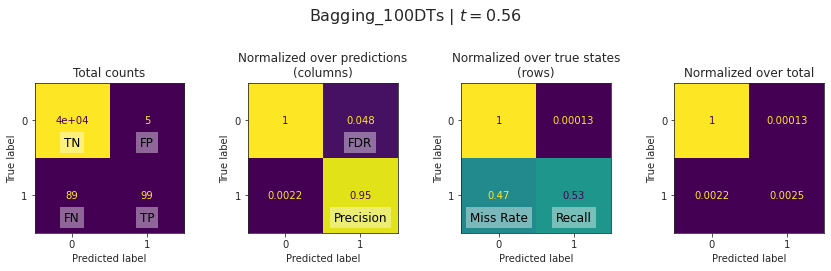

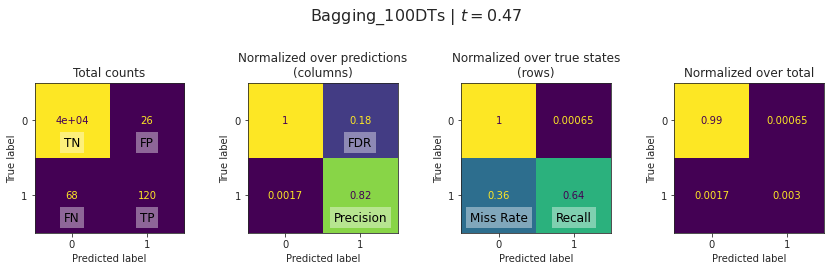

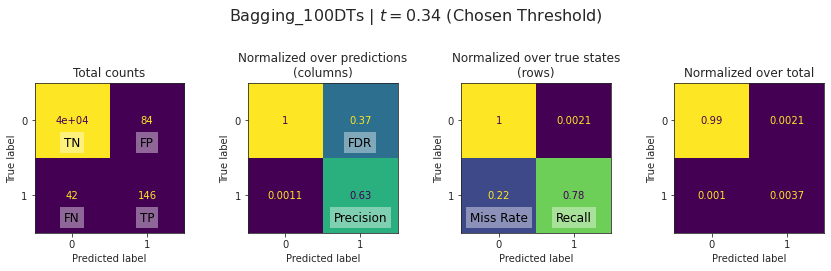

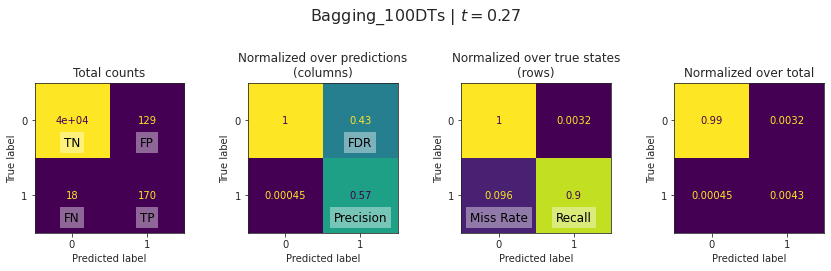

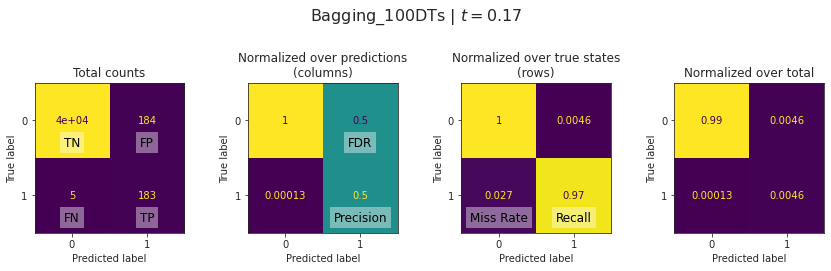

In [426]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from IPython.display import HTML
import matplotlib.pyplot as plt

sns.set_style("ticks")

def display_confusion(y_true, y_pred, title):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))
    
    common_opts = [y_true, y_pred]
    
    ConfusionMatrixDisplay.from_predictions(*common_opts, ax=ax1, colorbar=False, normalize=None)
    ConfusionMatrixDisplay.from_predictions(*common_opts, ax=ax2, colorbar=False, normalize="pred")
    ConfusionMatrixDisplay.from_predictions(*common_opts, ax=ax3, colorbar=False, normalize="true")
    ConfusionMatrixDisplay.from_predictions(*common_opts, ax=ax4, colorbar=False, normalize="all")

    ax1.set_title("Total counts")
    ax2.set_title("Normalized over predictions\n(columns)")
    ax3.set_title("Normalized over true states\n(rows)")
    ax4.set_title("Normalized over total")

    text_opts = dict(
        ha="center", va="center",
        fontsize=12,
        color="Black",
        bbox=dict(
            facecolor="White", edgecolor='none',
            alpha=0.4,
        )
    )

    ax1.text(0, 0.3, "TN", **text_opts)
    ax1.text(1, 0.3, "FP", **text_opts)
    ax1.text(0, 1.3, "FN", **text_opts)
    ax1.text(1, 1.3, "TP", **text_opts)
    ax3.text(1, 1.3, "Recall", **text_opts)
    ax3.text(0, 1.3, "Miss Rate", **text_opts)
    ax2.text(1, 0.3, "FDR", **text_opts)
    ax2.text(1, 1.3, "Precision", **text_opts)

    plt.tight_layout()

    fig.suptitle(title, y=1.2, fontsize=16)

for thr in possible_thresholds:
    thr = thr.threshold
    
    title = f"{chosen_model_name} | $t = {thr}$"
    if thr == chosen_threshold:
        title += " (Chosen Threshold)"
    y_pred = (y_prob >= thr).astype(int)
    display_confusion(y_true, y_pred, title)
    plt.show()

In [461]:
thresholds_fp = f"{thresholds_dir }/{chosen_model_name}.thresholds.csv"
thresholds.round(2).drop(np.nan).to_csv(thresholds_fp, index=False)
print(thresholds_fp)

results/models_big/Bagging_100DTs.thresholds.csv


## Full precision-recall data for reference

In [460]:
pd.set_option("display.max_rows", 100)
thresholds.dropna().drop("threshold", axis=1).round(3) * 100

,precision,recall,F1,F2
threshold,,,,
0.00,0.5,100.0,0.9,2.3
0.01,20.4,100.0,33.9,56.2
0.02,27.4,100.0,43.0,65.4
0.03,32.1,100.0,48.6,70.3
0.04,34.9,100.0,51.8,72.9
0.05,37.6,100.0,54.7,75.1
0.06,39.9,100.0,57.1,76.9
0.07,41.8,100.0,58.9,78.2
0.08,42.5,100.0,59.7,78.7


## Feature importance

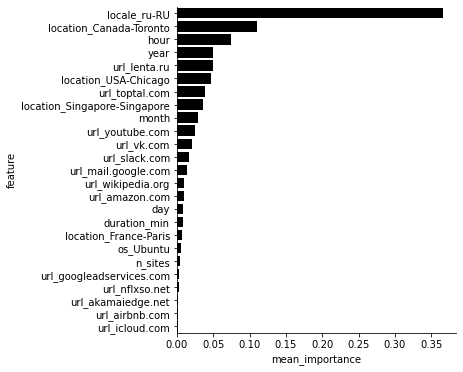

In [61]:
import seaborn as sns

importances = np.mean([tree.feature_importances_ for tree in chosen_model.estimators_], axis=0)
importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
importances = importances.reset_index()
importances.columns = ["feature", "mean_importance"]

fig, ax = plt.subplots(1, 1, figsize=(5, 6))

sns.barplot(
    data=importances.head(25),
    x="mean_importance",
    y="feature",
    color="k",
    linewidth=0,
    ax=ax
)

sns.despine(ax=ax)